In [1]:
# Importing the necessary libraries
import pandas as pd 
pd.set_option('max_colwidth',None)
from imutils import build_montages
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# Loading the image details data
image_data = pd.read_csv('complete_image_data_with_labels.csv')
print(image_data.shape)
image_data.head()

(206, 2)


,s3_img_path,user_id
0,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/1/1_1.jpg,1
1,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/1/1_2.jpg,1
2,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_1.jpg,10
3,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_2.jpg,10
4,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_3.jpg,10


In [3]:
# Image pair generator function
def make_pairs(images, labels):
    # initialize two empty lists to hold the (image, image) pairs and
	# labels to indicate if a pair is positive or negative
	pairImages = []
	pairLabels = []    

	# calculate the total number of classes present in the dataset
	# and then build a list of indexes for each class label that
	# provides the indexes for all examples with a given label
	numClasses = len(np.unique(labels))
	img_idx = [np.where(labels == i)[0] for i in range(1, numClasses+1)]
	# print(len(img_idx))

    # loop over all images
	for idxA in range(len(images)):
		# grab the current image and label belonging to the current
		# iteration
		currentImage = images[idxA]
		label = labels[idxA]
		# print(len(label))
		# print(label)

		# Positive Pairs
		# randomly pick an image that belongs to the *same* class
		# label
		idxB = np.random.choice(img_idx[label-1])
		# print(idxB)
		posImage = images[idxB]
		# prepare a positive pair and update the images and labels
		# lists, respectively
		pairImages.append([currentImage, posImage])
		pairLabels.append([1])

		# Negative Pairs
		# grab the indices for each of the class labels *not* equal to
		# the current label and randomly pick an image corresponding
		# to a label *not* equal to the current label
		negIdx = np.where(labels != label)[0]
		negImage = images[np.random.choice(negIdx)]
		# prepare a negative pair of images and update our lists
		pairImages.append([currentImage, negImage])
		pairLabels.append([0])

	# return a 2-tuple of our image pairs and labels
	return (np.array(pairImages), np.array(pairLabels))

In [4]:
# calculate the total number of classes present in the dataset
# and then build a list of indexes for each class label that
# provides the indexes for all examples with a given label


labels = image_data.user_id
numClasses = len(np.unique(labels))
idx = [np.where(labels == i)[0] for i in range(1, numClasses+1)]

In [5]:
# Understanding how to get row indexes for each class
# for i in range(1, numClasses+1):
#     idxs = np.where(labels == i)[0]
#     print("{}: {} {}".format(i, len(idxs), idxs))

In [6]:
# from tensorflow.keras.datasets import mnist

# # load MNIST dataset and scale the pixel values to the range of [0, 1]
# print("[INFO] loading MNIST dataset...")
# (trainX, trainY), (testX, testY) = mnist.load_data()
# # build the positive and negative image pairs
# print("[INFO] preparing positive and negative pairs...")
# (pairTrain, labelTrain) = make_pairs(trainX, trainY)
# (pairTest, labelTest) = make_pairs(testX, testY)
# # initialize the list of images that will be used when building our
# # montage


In [7]:
# trainX[0].shape

In [8]:
# Example
# bucket = 'hariharan-project-data'
# key = 'Banking-and-Finance/Face-Recognition-KYC-Tool/Data/12/12_2.jpg'
# obj = s3_client.get_object(Bucket=bucket, Key = key)
# file_stream = obj['Body']
# im = Image.open(file_stream)

# im_array = np.array(im)
# im_array.shape

# im

In [10]:
# from PIL import Image
# import boto3
# from io import BytesIO
# import numpy as np
# import aws_access

# s3_client = boto3.client('s3', aws_access_key_id = aws_access.aws_access_key_id, 
#                                 aws_secret_access_key = aws_access.aws_secret_access_key)

# def read_image_from_s3(bucket, key, region_name='us-east-1'):
#     """Load image file from s3.

#     Parameters
#     ----------
#     bucket: string
#         Bucket name
#     key : string
#         Path in s3

#     Returns
#     -------
#     np array
#         Image array
#     """
#     obj = s3_client.get_object(Bucket=bucket, Key = key)
#     file_stream = obj['Body']
#     im = Image.open(file_stream)
#     return np.array(im)


from PIL import Image
import boto3
from io import BytesIO
import numpy as np
import aws_access

s3_client = boto3.client('s3', aws_access_key_id = aws_access.aws_access_key_id, 
                                aws_secret_access_key = aws_access.aws_secret_access_key)

def read_image_from_s3_with_face(bucket, key, region_name='us-east-1'):
    """Load image file from s3.

    Parameters
    ----------
    bucket: string
        Bucket name
    key : string
        Path in s3

    Returns
    -------
    np array
        Image array
    """
    obj = s3_client.get_object(Bucket=bucket, Key = key)
    file_stream = obj['Body']
    im = Image.open(file_stream) #.convert('L')
    # print(type(im))
    # plt.imshow(im)
    # print(np.array(im).shape)

    # Convert into grayscale
    gray = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2GRAY)
    # gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    # plt.imshow(gray)

    # Load the cascade
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    # Draw rectangle around the faces and crop the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(gray, (x, y), (x+w, y+h), (0, 0, 255), 2)
        faces = gray[y:y + h, x:x + w]
        faces = cv2.resize(faces, (256,256))
        # cv2.imshow("face",faces)
        # plt.imshow(faces)
        # cv2.imwrite('face.jpg', faces)
    
    return np.array(faces)    

In [11]:
image_data.head()

,s3_img_path,user_id
0,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/1/1_1.jpg,1
1,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/1/1_2.jpg,1
2,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_1.jpg,10
3,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_2.jpg,10
4,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_3.jpg,10


In [12]:
image_data.loc[54,'s3_img_path'].split('data/')[1]

'Banking-and-Finance/Face-Recognition-KYC-Tool/Data/24/24_2.jpg'

In [13]:
# Getting image in the form of arrays from the filePaths
image_array_list = []

for i in range(len(image_data)):
    s3_img_path = image_data.loc[i,'s3_img_path']
    bucket = 'hariharan-project-data'
    key = s3_img_path.split('data/')[1]
    img_array = read_image_from_s3_with_face(bucket=bucket,key=key)
    image_array_list.append(img_array)

In [14]:
len(image_array_list)

206

In [15]:
image_array_list[6].shape

(256, 256)

In [16]:
# np.array(image_array_list).shape

In [17]:
# Creating Training and Test set
from sklearn.model_selection import train_test_split

X = np.array(image_array_list)
Y = image_data.user_id.values 

# x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.3)
# print(x_train.shape, x_test.shape)
# print(y_train.shape, y_test.shape)

# Creating test data (one images from all the classes)
numClasses = len(np.unique(Y))
idx_test = [np.where(labels == i)[0][0] for i in range(1, numClasses+1)]  
print("Size of test data: ", len(idx_test))
y_test = Y[idx_test]
x_test = X[idx_test]
x_test = x_test/255.0
print("Test Data: ", (x_test.shape, y_test.shape))

# Creating train data
idx_train = [i for i in range(len(Y)) if i not in idx_test]
print("\nSize of train data: ", len(idx_train))
y_train = Y[idx_train]
x_train = X[idx_train]
x_train = x_train/255.0
print("Train Data: ", (x_train.shape, y_train.shape))



Size of test data:  50
Test Data:  ((50, 256, 256), (50,))

Size of train data:  156
Train Data:  ((156, 256, 256), (156,))


In [18]:
# build the positive and negative image pairs
print("Preparing positive and negative pairs...")
(pairTrain, labelTrain) = make_pairs(x_train, y_train)
(pairTest, labelTest) = make_pairs(x_test, y_test)

print("Size of Train Data: "+str(pairTrain.shape))
print("Size of Test Data: "+str(pairTest.shape))

Preparing positive and negative pairs...
Size of Train Data: (312, 2, 256, 256)
Size of Test Data: (100, 2, 256, 256)


The Target is: [0]


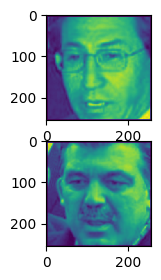

In [20]:
# Visualizing the image pairs to check if our make_pairs function is working well
sel = np.random.choice(np.arange(0,len(pairTrain)))
imageA = pairTrain[sel][0]
imageB = pairTrain[sel][1]
label = labelTrain[sel]

print("The Target is: "+str(label))
fig, ax = plt.subplots(2,1,figsize=(3, 3))
ax[0].imshow(imageA,interpolation='nearest')
ax[1].imshow(imageB,interpolation='nearest')

In [22]:
from siamese_network import build_siamese_model

input_shape = (256,256,1)
model1 = build_siamese_model(input_shape)

In [23]:
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 128)     1280      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 128)    0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        7379

In [24]:
import tensorflow.keras.backend as K

def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors

	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)
        
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [25]:
def plot_training(H, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda

In [27]:
import config
config.IMG_SHAPE

(256, 256, 1)

In [28]:
# configure the siamese network
import config

print("[INFO] building siamese network...")
imgA = Input(shape=config.IMG_SHAPE)
imgB = Input(shape=config.IMG_SHAPE)
featureExtractor = build_siamese_model(config.IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

# finally, construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

[INFO] building siamese network...


In [29]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)           (None, 64)           239232      ['input_3[0][0]',                
                                                                  'input_4[0][0]']          

In [30]:
print(config.EPOCHS)
print(config.BATCH_SIZE)

20
64


In [31]:
# compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy"])

# train the model
print("[INFO] training model...")
history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=config.BATCH_SIZE, 
	epochs=config.EPOCHS)

[INFO] compiling model...
[INFO] training model...
Epoch 1/20
4/5 [=======================>......] - ETA: 28s - loss: 0.6933 - accuracy: 0.4648

[INFO] saving siamese model...


INFO:tensorflow:Assets written to: output/siamese_model/assets


INFO:tensorflow:Assets written to: output/siamese_model/assets


[INFO] plotting training history...


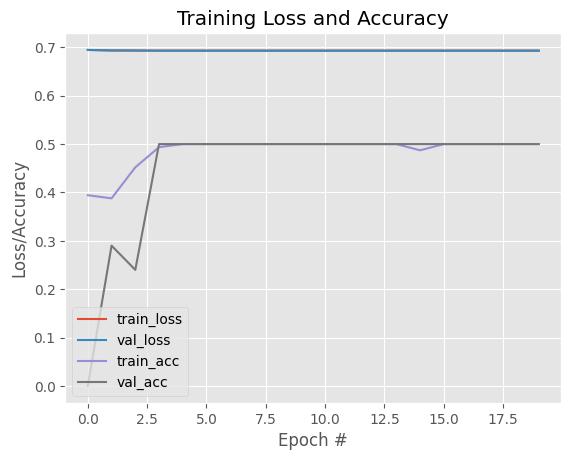

In [82]:
# serialize the model to disk
print("[INFO] saving siamese model...")
model.save(config.MODEL_PATH)

# plot the training history
print("[INFO] plotting training history...")
plot_training(history, config.PLOT_PATH)

# Testing the Siamese Network:

In [83]:
from PIL import Image
import boto3
from io import BytesIO
import numpy as np
import aws_access

s3_client = boto3.client('s3', aws_access_key_id = aws_access.aws_access_key_id, 
                                aws_secret_access_key = aws_access.aws_secret_access_key)

def view_image_from_s3(bucket, key, region_name='us-east-1'):
    """Load image file from s3.

    Parameters
    ----------
    bucket: string
        Bucket name
    key : string
        Path in s3

    Returns
    -------
    np array
        Image array
    """
    obj = s3_client.get_object(Bucket=bucket, Key = key)
    file_stream = obj['Body']
    im = Image.open(file_stream)
    plt.imshow(im)
    # return np.array(im)

In [84]:
image_data.head()

,s3_img_path,user_id
0,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/1/1_1.jpg,1
1,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/1/1_2.jpg,1
2,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_1.jpg,10
3,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_2.jpg,10
4,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_3.jpg,10


Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_1.jpg


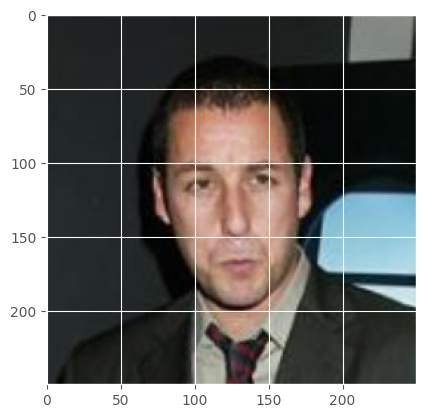

In [85]:
# Checking the image of the users based on user_id from the azure sql database table 
sel = 10
s3_img_path = image_data[image_data['user_id']==sel]['s3_img_path'].values.tolist()[0]
bucket = 'hariharan-project-data'
key = s3_img_path.split('hariharan-project-data/')[1]
print(key)
img_array = view_image_from_s3(bucket=bucket,key=key)

In [36]:
# input from user will be one image
# code should take that image and get the probability score for that image with all the other image in our database
# Then return the image (or the details of the image) that has higher probability

In [37]:
# Test data - single image sample for all the users in our dataset
x_test.shape

(50, 250, 250, 3)

In [38]:
# Create a users repo directory in the cloud (preferrable s3) which has one image per user in a folder name as the ID
# Or randomly take one image from each user directory which is used for training while testing (TRY THIS FIRST)
# If a new user uploads images then save the images in the directory with proper id and directory path


In [39]:
image_data.head()

,s3_img_path,user_id
0,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/1/1_1.jpg,1
1,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/1/1_2.jpg,1
2,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_1.jpg,10
3,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_2.jpg,10
4,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_3.jpg,10


In [40]:
# Getting image in the form of arrays from the filePaths
image_array_list = []

for i in range(len(image_data)):
    s3_img_path = image_data.loc[i,'s3_img_path']
    bucket = 'hariharan-project-data'
    key = s3_img_path.split('data/')[1]
    img_array = read_image_from_s3(bucket=bucket,key=key)
    image_array_list.append(img_array)

In [86]:
len(image_array_list)

206

In [87]:
# Creating a Scoring set
X = np.array(image_array_list)
Y = image_data.user_id.values 

# x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.3)
# print(x_train.shape, x_test.shape)
# print(y_train.shape, y_test.shape)

# Creating test data (one images from all the classes)
labels = image_data.user_id
numClasses = len(np.unique(Y))
idx_test = [np.where(labels == i)[0][0] for i in range(1, numClasses+1)]  
print("Size of scoring data: ", len(idx_test))
y_test = Y[idx_test]
x_test = X[idx_test]
print("Scoring Data: ", (x_test.shape, y_test.shape))

Size of scoring data:  50
Scoring Data:  ((50, 128, 128), (50,))


In [88]:
# import the necessary packages
import config
import utils
from tensorflow.keras.models import load_model
from imutils.paths import list_images
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

In [89]:
print("[INFO] loading test dataset...")
path = "examples"
testImagePaths = list(list_images(path))
testImagePaths

[INFO] loading test dataset...


['examples/10.png',
 'examples/38.png',
 'examples/Parker_35_example.png',
 'examples/35.png']

In [90]:
# grab the test dataset image paths and then randomly generate a
# total of 10 image pairs
print("[INFO] loading test dataset...")
path = "examples"
testImagePaths = list(list_images(path))
print("Total Number of images in the examples: "+str(len(testImagePaths)))

# np.random.seed(42)
# pairs = np.random.choice(testImagePaths, size=(10, 2))

# load the model from disk
print("[INFO] loading siamese model...")
model = load_model(config.MODEL_PATH)

[INFO] loading test dataset...
Total Number of images in the examples: 4
[INFO] loading siamese model...


examples/Parker_35_example.png
(128, 128)


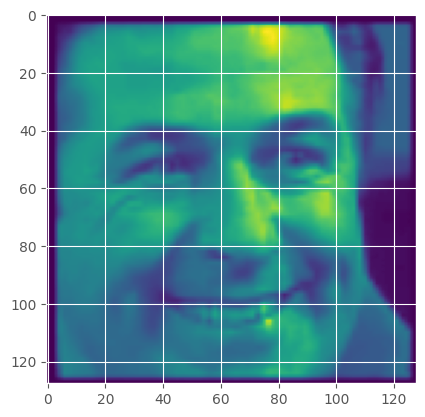

In [108]:
print(testImagePaths[2])
imageA = cv2.imread(testImagePaths[2])
imageA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
imageA = cv2.resize(imageA,(256,256))
# imageA = imageA/255.0
# imageA.shape
# plt.imshow(imageA)

# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  
# Detect faces
faces = face_cascade.detectMultiScale(imageA, 1.1, 4)

# Draw rectangle around the faces and crop the faces
for (x, y, w, h) in faces:
    cv2.rectangle(imageA, (x, y), (x+w, y+h), (0, 0, 255), 2)
    faces = imageA[y:y + h, x:x + w]
    faces = cv2.resize(faces, (128,128))

print(np.array(faces).shape)
imageA = np.array(faces)

plt.imshow(imageA)

In [103]:
y_test

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [104]:
# plt.imshow(x_test[21])

In [105]:
# for i, imageB in enumerate(x_test[:3]):
#     print(imageB.shape)
#     plt.imshow(imageB)

In [109]:
prediction_probs = []
# x_test[34]

# imageA = cv2.imread(testImagePaths[0])
# imageA = cv2.resize(imageA,(250,250))
# imageA = imageA/255.0
# imageA.shape

for i, imageB in enumerate(x_test):
	
	if i != 0:
		imageA = origA.copy()
		
    # create a copy of both the images for visualization purpose
	origA = imageA.copy()
	origB = imageB.copy()

	# # add channel a dimension to both the images
	# imageA = np.expand_dims(imageA, axis=-1)
	# imageB = np.expand_dims(imageB, axis=-1)
	
	# add a batch dimension to both images
	imageA = np.expand_dims(imageA, axis=0)
	imageB = np.expand_dims(imageB, axis=0)
	print(imageA.shape)
	print(imageB.shape)

    # scale the pixel values to the range of [0, 1]
	imageA = imageA / 255.0
	imageB = imageB / 255.0

	# use our siamese model to make predictions on the image pair,
	# indicating whether or not the images belong to the same class
	preds = model.predict([imageA, imageB])
	proba = preds[0][0]
	prediction_probs.append(proba)

(1, 128, 128)
(1, 128, 128)
1/1 [==============================] - 0s 189ms/step
(1, 128, 128)
(1, 128, 128)
1/1 [==============================] - 0s 46ms/step
(1, 128, 128)
(1, 128, 128)
1/1 [==============================] - 0s 44ms/step
(1, 128, 128)
(1, 128, 128)
1/1 [==============================] - 0s 44ms/step
(1, 128, 128)
(1, 128, 128)
1/1 [==============================] - 0s 44ms/step
(1, 128, 128)
(1, 128, 128)
1/1 [==============================] - 0s 45ms/step
(1, 128, 128)
(1, 128, 128)
1/1 [==============================] - 0s 43ms/step
(1, 128, 128)
(1, 128, 128)
1/1 [==============================] - 0s 44ms/step
(1, 128, 128)
(1, 128, 128)
1/1 [==============================] - 0s 45ms/step
(1, 128, 128)
(1, 128, 128)
1/1 [==============================] - 0s 43ms/step
(1, 128, 128)
(1, 128, 128)
1/1 [==============================] - 0s 43ms/step
(1, 128, 128)
(1, 128, 128)
1/1 [==============================] - 0s 45ms/step
(1, 128, 128)
(1, 128, 128)
1/1 [======

In [110]:
print(prediction_probs)

[0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017]


In [111]:
print(prediction_probs)

[0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017, 0.49986017]


In [112]:
# print(prediction_probs)

In [113]:
print(len(prediction_probs))     
print(np.argmax(prediction_probs))

y_test[np.argmax(prediction_probs)]

50
0


1

In [55]:
y_test

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

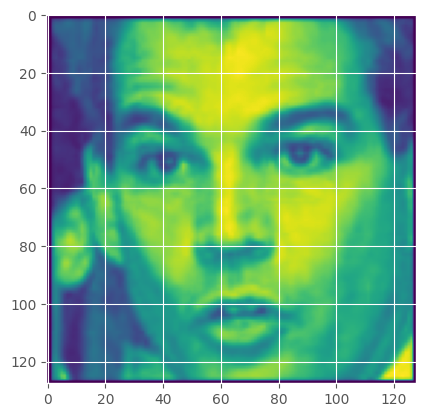

In [114]:
plt.imshow(x_test[45])

## Detecting Faces from the images using Haar Cascasde:

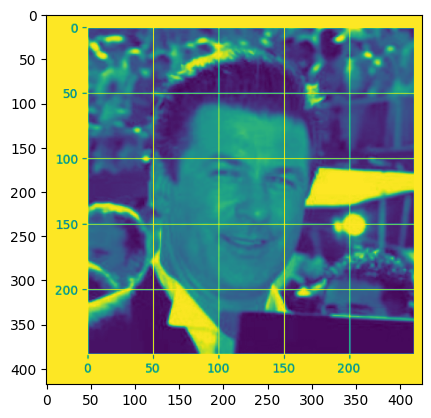

In [7]:
import cv2
import matplotlib.pyplot as plt
  
# Read the input image
img = cv2.imread('examples/35.png')
  
# Convert into grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)
  

In [8]:
# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  
# Detect faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)

In [9]:
# Draw rectangle around the faces and crop the faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    faces = img[y:y + h, x:x + w]
    cv2.imshow("face",faces)
    cv2.imwrite('face.jpg', faces)
      
# Display the output
cv2.imwrite('detcted.jpg', img)
cv2.imshow('img', img)
# cv2.waitKey()

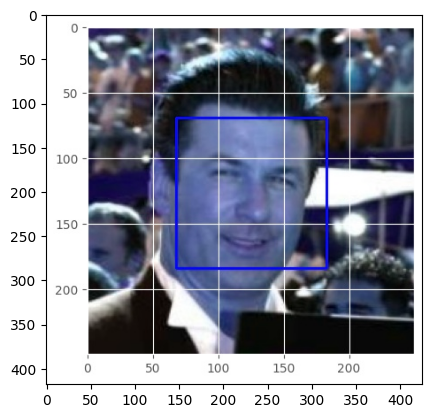

In [10]:
detected = cv2.imread('detcted.jpg')
plt.imshow(detected)

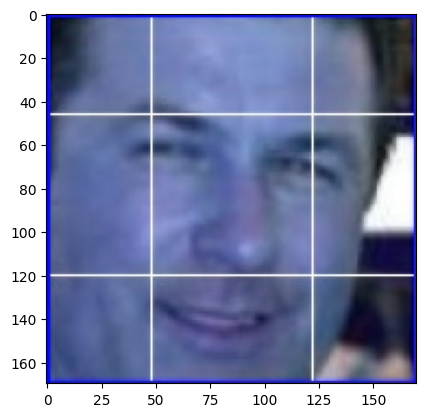

In [11]:
face = cv2.imread('face.jpg')
plt.imshow(face)

Banking-and-Finance/Face-Recognition-KYC-Tool/Data/50/50_1.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>


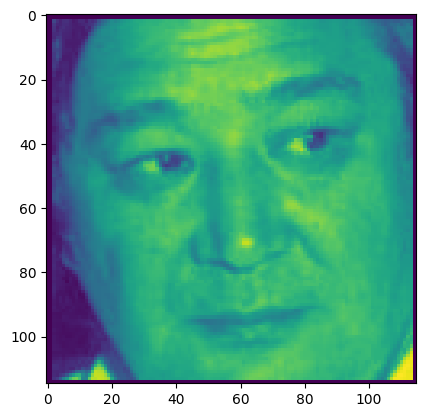

In [39]:
# Checking the image of the users based on user_id from the azure sql database table 
sel = 50
s3_img_path = image_data[image_data['user_id']==sel]['s3_img_path'].values.tolist()[0]
bucket = 'hariharan-project-data'
key = s3_img_path.split('hariharan-project-data/')[1]
print(key)
img_array = read_image_from_s3_with_face(bucket=bucket,key=key)